In [2]:
import pandas as pd
import numpy as np
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load all training curves
train_meta = pd.read_csv('../data/training_set_metadata.csv')
train = pd.read_csv('../data/training_set.csv')

# Create class dict
oid_class = dict(zip(train_meta['object_id'], train_meta['target']))

# Create class column in train data
train['target'] = train['object_id'].map(oid_class)

# Group oids by class
gp = train.groupby(['target'])['object_id']
oids_by_class = {tgt : gp.get_group(tgt).unique() for tgt in train_meta['target'].unique()}

/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/site-packages/numpy/lib/histograms.py:789: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/lanfear/anaconda3/en

(-1, 1000)

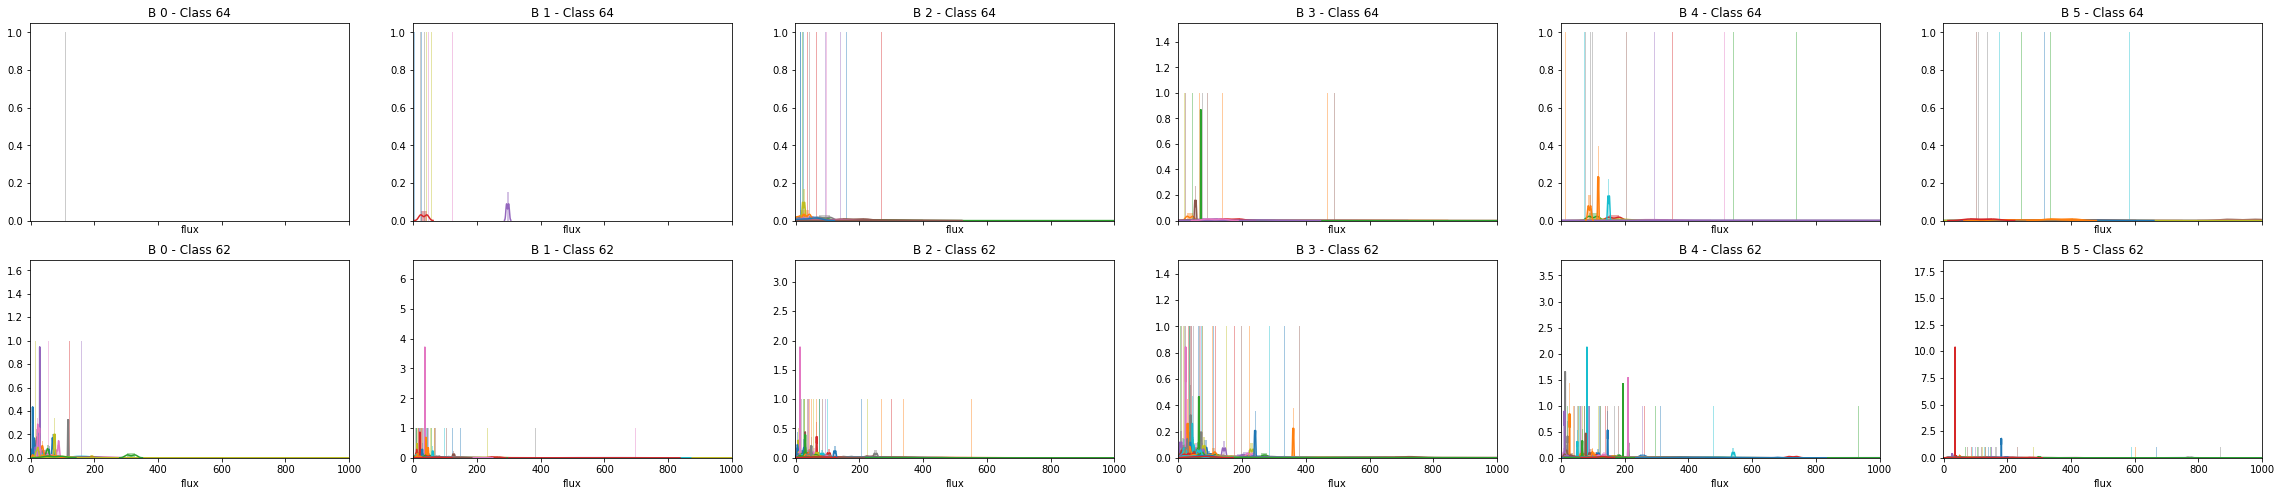

In [28]:
_cs = [64, 62]

f,axes = plt.subplots(len(_cs),6,figsize=(40,len(_cs)*4), sharex=True)

for i,tgt in enumerate(_cs):
    for oid in oids_by_class[tgt][:]:
        for pb in range(6):
            single_pb = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1.0),
                'flux'
            ]
            sns.distplot(single_pb, ax=axes[i, pb], label=f'band {pb:d}')
            axes[i, pb].set_title(f'B {pb:d} - Class {tgt:d}')

plt.xlim(-1,1000)
#f.savefig('../fluxz_err.png')

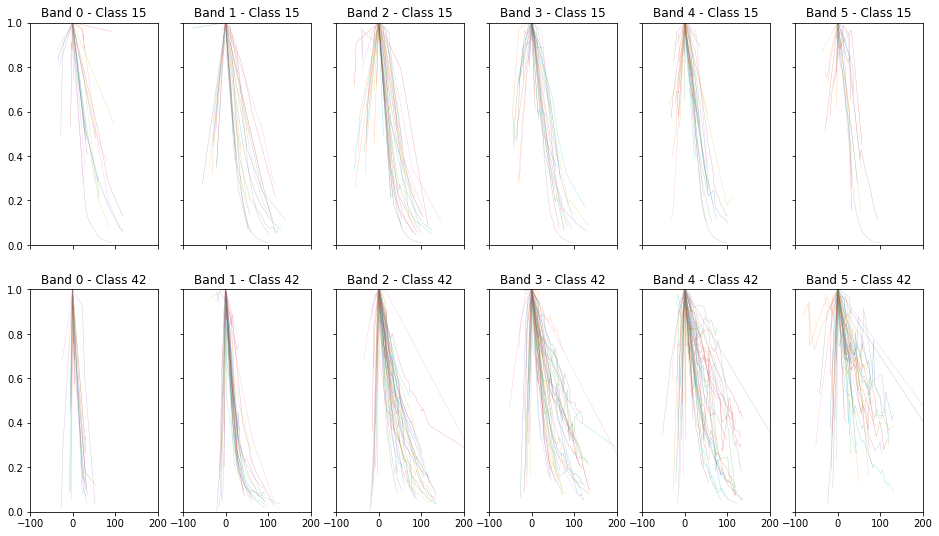

In [9]:
f,axes = plt.subplots(2,6,figsize=(16,9), sharex=True, sharey=True)

for i,tgt in enumerate([15, 42]):
    for oid in oids_by_class[tgt][:60]:
        for pb in range(6):
            mjd = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'mjd'
            ].values
            flux = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'flux'
            ].values
            
            # Find flux peak to allign peaks
            if len(flux)>0:
                peak_pos = np.argmax(flux)
                flux /= flux[peak_pos]
                mjd = mjd - mjd[peak_pos]

                sns.lineplot(x=mjd, y=flux, linewidth=0.4, alpha=0.4, ax=axes[i, pb])
                axes[i, pb].set_title(f'Band {pb:d} - Class {tgt:d}')
                axes[i, pb].set_ylabel('')

plt.xlim(-100,200)
plt.ylim(0,1)
f.savefig('../flux_confusion_v1.png')

/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[0.11975789 0.3873757  0.71768266 0.68568958 0.64288802 0.33938608]
 [0.00961538 0.24038462 0.58173077 0.59615385 0.625      0.39903846]
 [0.13114754 0.43715847 0.79234973 0.76502732 0.68306011 0.44262295]]


<Figure size 432x288 with 0 Axes>

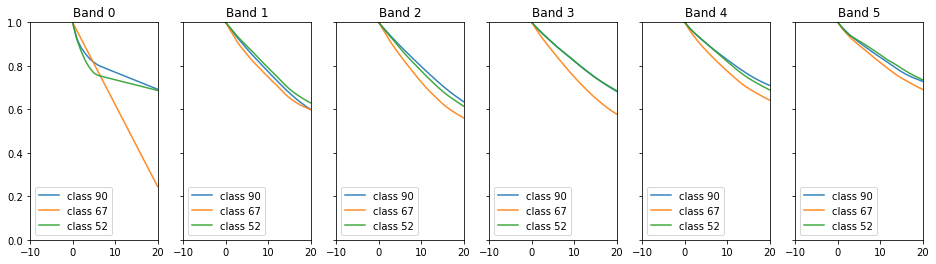

In [8]:
plt.cla()
plt.clf()

f,axes = plt.subplots(1,6,figsize=(16,4), sharex=True, sharey=True)

n_meas = np.zeros((3,6))
_classes = [90, 67, 52]

noids = np.array([len(oids_by_class[tgt]) for tgt in _classes])

for i,tgt in enumerate(_classes):
    
    for pb in range(6):
        
        max_mjd = 20
        fluxes = []
        standard_time_stamps = np.linspace(0, max_mjd, 50)
        
        for oid in oids_by_class[tgt][:noids[i]]:
            mjd = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'mjd'
            ].values
            flux = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'flux'
            ].values
            
            # Find flux peak to allign peaks
            if len(flux)>1:
                peak_pos = np.argmax(flux)
                flux /= flux[peak_pos]
                mjd = mjd - mjd[peak_pos]
                
                n_meas[i, pb] += 1
                
                # Interp flux to standard timestamps
                interp_flux = np.interp(standard_time_stamps, mjd, flux, left=1)
                fluxes.append(interp_flux)
            
            flux = np.mean(fluxes, axis=0)

        sns.lineplot(x=standard_time_stamps, y=flux, linewidth=1.5, alpha=0.9, ax=axes[pb], label=f'class {tgt:d}')
        axes[pb].set_title(f'Band {pb:d}')
        axes[pb].set_ylabel('')

plt.legend()
plt.xlim(-10,max_mjd)
plt.ylim(0,1)
print(n_meas/noids[:, None])

In [16]:
len(oids_by_class[52])

183

In [23]:
a = np.array([
    1.001044,
        1.001044,
        1.001044,
        1.001044,
        1.001044,
        2.007104,
        1.001044,
        1.000000,
        1.001044,
        1.001044,
        1.001044,
        2.001886,
        1.001044,
]
        
)

In [25]:
a[::-1]

array([1.001044, 2.001886, 1.001044, 1.001044, 1.001044, 1.      ,
       1.001044, 2.007104, 1.001044, 1.001044, 1.001044, 1.001044,
       1.001044])

In [29]:
len(oids_by_class[64])

102

In [55]:
train = train[train['target']==64]
a = train.groupby(['object_id', 'passband'])['detected'].sum().reset_index('passband')
a.groupby('passband')['detected'].max()

passband
0    1
1    2
2    3
3    3
4    4
5    2
Name: detected, dtype: int64